In [283]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from data import data_keys
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer as SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn_pandas import CategoricalImputer
import seaborn as sns
from scipy import sparse
import helpers
import operator
import warnings
from functools import reduce
from ast import literal_eval
warnings.filterwarnings('ignore')

from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt

In [179]:
import importlib
importlib.reload(data_keys)
importlib.reload(helpers)
# from data import data_keys

save_imgs = False

This is a relatively large dataset with about 100 columns.
For this challenge, the variables we would try to predict are prices and availability.

In [180]:
df = pd.read_csv("./data/listings.csv", converters={"host_verifications": literal_eval})
print("Shape: ", df.shape)
df.describe()

Shape:  (20677, 106)


,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.067700e+04,2.067700e+04,0.0,0.0,0.0,2.067700e+04,0.0,20665.000000,20665.000000,0.0,...,17852.000000,17840.000000,17847.000000,17842.000000,17842.000000,20677.000000,20677.000000,20677.000000,20677.000000,18084.000000
mean,1.791013e+07,2.019081e+13,NaN,NaN,NaN,5.666981e+07,NaN,7.010888,7.010888,NaN,...,9.469079,9.735762,9.789488,9.476124,9.177054,4.925134,4.492431,0.410988,0.021715,0.987736
std,1.041987e+07,7.800970e+00,NaN,NaN,NaN,6.812902e+07,NaN,37.729548,37.729548,NaN,...,0.867372,0.654358,0.610074,0.707655,0.808275,22.883678,22.710906,1.082794,0.237805,1.349155
min,2.818000e+03,2.019081e+13,NaN,NaN,NaN,3.159000e+03,NaN,0.000000,0.000000,NaN,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,9.340207e+06,2.019081e+13,NaN,NaN,NaN,8.795077e+06,NaN,1.000000,1.000000,NaN,...,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.240000
50%,1.774427e+07,2.019081e+13,NaN,NaN,NaN,2.618942e+07,NaN,1.000000,1.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.540000
75%,2.601974e+07,2.019081e+13,NaN,NaN,NaN,7.754037e+07,NaN,2.000000,2.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,1.070000
max,3.759099e+07,2.019081e+13,NaN,NaN,NaN,2.839422e+08,NaN,980.000000,980.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,208.000000,206.000000,15.000000,8.000000,33.670000


Analyze availability

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023FBB186780>,
      dtype=object)

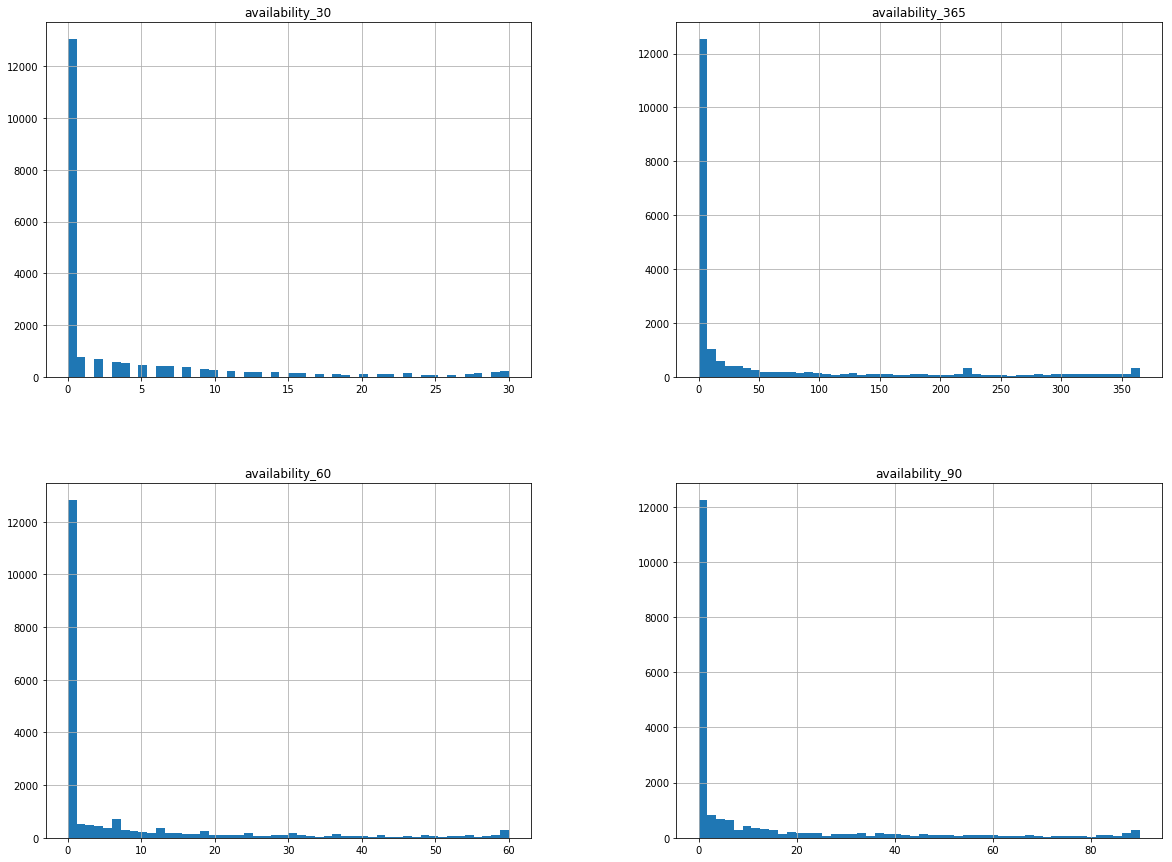

In [181]:
df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].hist(bins=50, figsize=(20,15))

The distribution of availability is non-normal and has very wide (uniform after 0) spread.
Thus, we could bin the variable into some intervals. 

Notice the std increases as the time length considered increases, thus differentiating the listings more.
Let's use 'availability_365' since they are all highly correlated and the availability for 365 days could eliminate short-term fluctuations that we don't care.
* Note the types/locations might be good predictors for short-term availability.

## Work with price first

## Data cleaning

In [182]:
num_attribs = data_keys.primary_num_cols + ["price"]

In [183]:

# convert certain string-based values to a numerical column
nan_ptc_dict = {}
for price_col in list(df):
    count_nan = len(df[price_col]) - df[price_col].count()
    if (count_nan):
        nan_ptc_dict[f"nan percentage for {price_col}"] = count_nan / len(df)

In [184]:
sorted_d = sorted(nan_ptc_dict.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_d)

[('nan percentage for thumbnail_url', 1.0), ('nan percentage for medium_url', 1.0), ('nan percentage for xl_picture_url', 1.0), ('nan percentage for host_acceptance_rate', 1.0), ('nan percentage for neighbourhood_group_cleansed', 1.0), ('nan percentage for license', 0.9987909271170866), ('nan percentage for square_feet', 0.9813319146878173), ('nan percentage for monthly_price', 0.9319050152343183), ('nan percentage for weekly_price', 0.8746916864148571), ('nan percentage for notes', 0.557285873192436), ('nan percentage for host_about', 0.41592107172220344), ('nan percentage for host_response_time', 0.4130676597185278), ('nan percentage for host_response_rate', 0.4130676597185278), ('nan percentage for access', 0.40953716690042075), ('nan percentage for interaction', 0.38632296754848383), ('nan percentage for house_rules', 0.3812448614402476), ('nan percentage for neighborhood_overview', 0.3184214344440683), ('nan percentage for transit', 0.3047830923248053), ('nan percentage for securi

Most variables are relatively complete. We would drop square_feet.  

In [185]:
df, num_attribs = helpers.drop_attribs(df, num_attribs, ['square_feet'])

In [186]:
df["host_response_rate"] = df["host_response_rate"].apply(lambda x: helpers.percent_to_float(x))

for col in ["price", "security_deposit", "cleaning_fee", "extra_people"]:
    df[col] = df[col].apply(lambda x: helpers.convert_string_to_dollar(str(x)))

df = df[(df["price"] > 0) &
        (df["accommodates"] > 0)]

## Let's check the distributions for the numerical variables.

In [187]:
if save_imgs:
    sns.pairplot(df[num_attribs]).savefig("./imgs/pairplot.png")
    plt.close() # too many variables for inline plots

Correlation Heatmap

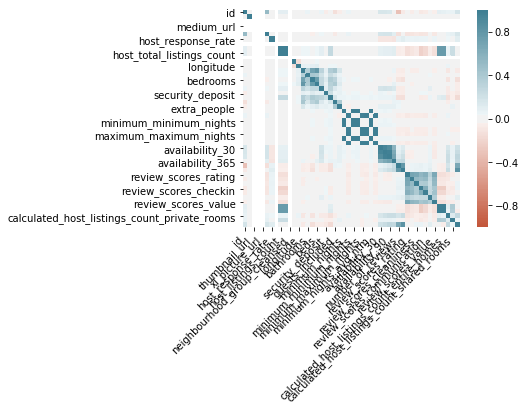

In [188]:
helpers.corr_heatmap(df.corr())

## Feature Transformation

Many variables are right skewed, so let's try log transformation

In [189]:
to_log_transform = ["price", "security_deposit", "cleaning_fee", "extra_people",
            "bathrooms", "bedrooms", "beds", "guests_included",
            "number_of_reviews"]

for col in to_log_transform:
    new_col_name = f"log_{col}"
    df[new_col_name] = np.log(df[col] + 1)
    num_attribs.append(new_col_name)

## Feature Engineering

In [190]:
base_col = "accommodates"
for col in ["bedrooms", "bathrooms"]:
    new_col_name = f"{col}_per_{base_col}"
    df[new_col_name] = df[col] / df[base_col]
    num_attribs.append(new_col_name)

In [191]:
review_col_names = ['review_scores_accuracy', 'review_scores_cleanliness', \
                   'review_scores_checkin', 'review_scores_communication', \
                   'review_scores_location', 'review_scores_value']
        
df['avg_review'] = df[review_col_names].mean(axis=1)

df[['review_scores_rating', "avg_review"] + review_col_names].corr()

,review_scores_rating,avg_review,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
review_scores_rating,1.000000,0.813368,0.683038,0.660347,0.541946,0.597463,0.342277,0.662979
avg_review,0.813368,1.000000,0.780069,0.740820,0.714878,0.729915,0.560879,0.785463
review_scores_accuracy,0.683038,0.780069,1.000000,0.530813,0.484389,0.528306,0.288246,0.548149
review_scores_cleanliness,0.660347,0.740820,0.530813,1.000000,0.374927,0.395964,0.242589,0.522499
review_scores_checkin,0.541946,0.714878,0.484389,0.374927,1.000000,0.618134,0.277944,0.429079
review_scores_communication,0.597463,0.729915,0.528306,0.395964,0.618134,1.000000,0.266880,0.457579
review_scores_location,0.342277,0.560879,0.288246,0.242589,0.277944,0.266880,1.000000,0.360936
review_scores_value,0.662979,0.785463,0.548149,0.522499,0.429079,0.457579,0.360936,1.000000


Actually there is not too strong correlations between the different types of reviews, for now let's just use review_scores_rating.

In [192]:
review_col_to_drop = review_col_names + ["avg_review"]
df, num_attribs = helpers.drop_attribs(df, num_attribs, review_col_to_drop)

Delete redundant variables

In [193]:
df, num_attribs = helpers.drop_attribs(df, num_attribs, to_log_transform)

Delete less useful variables

In [194]:
df, num_attribs = helpers.drop_attribs(df, num_attribs, ["minimum_nights", "maximum_nights"])

Inspect the pairplot and heatmap again.

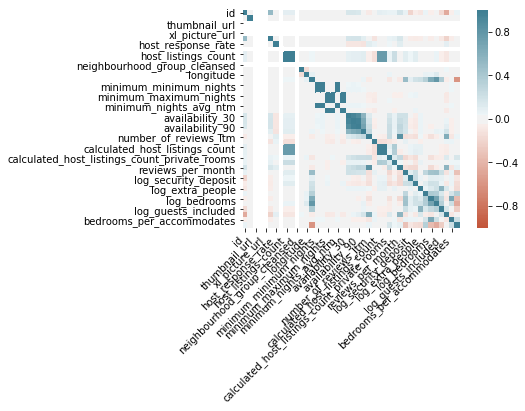

In [195]:
if save_imgs:
    sns.pairplot(df).savefig("./imgs/transformed_pairplot.png")
    plt.close() # too many variables for inline plots
    
helpers.corr_heatmap(df.corr())

The new plots much better as log_price is correlated with much more variables.

## Examine the categorical variables

In [196]:
cat_attribs = data_keys.binary_cols + data_keys.cat_cols

### Location
We see that attributes like host_neighbourhood, street, city, state, zipcode, and smart_location all describe locations, but the attribute neighbourhood_cleansed bins the data much better than any of them (it has less categories with more data in each one). We would use neighbourhood_cleansed then.  

In [197]:
unused_locations = ["host_neighbourhood", "street", "city", "state", "zipcode", "smart_location", "market"]
df, cat_attribs = helpers.drop_attribs(df, cat_attribs, unused_locations)

### Host verification 

In [198]:
all_verification_methods = [item for item in df["host_verifications"].tolist() if item]
all_verification_methods = set(reduce(lambda x, y: x+y, all_verification_methods))
all_verification_methods


{'email',
 'facebook',
 'google',
 'government_id',
 'identity_manual',
 'jumio',
 'kba',
 'manual_offline',
 'manual_online',
 'offline_government_id',
 'phone',
 'reviews',
 'selfie',
 'sent_id',
 'sesame',
 'sesame_offline',
 'weibo',
 'work_email',
 'zhima_selfie'}

### Engineer a verification categories
By looking at the verification methods, it appears that email, facebook, government_id, and phone would be good identification methods, so we construct a boolean feature that would be true if a host has any of those 

In [ ]:
good_verfication_methods = ["email", "facebook", "government_id", "phone"]

def is_nicely_verified(host_verifications):
    if not host_verifications:
        return "f"
    
    for ele in good_verfication_methods:
        if ele in host_verifications:
            return "t"
    
    return "f"

In [204]:

df["nicely_verified"] = df["host_verifications"].apply(lambda x: is_nicely_verified(x))
df["nicely_verified"].value_counts()

t    20456
f      220
Name: nicely_verified, dtype: int64

Only about 2% of the hosts are not "nicely verified", but we would still use it as a categorical variable. 

In [ ]:
cat_attribs.append("nicely_verified")
df, cat_attribs = helpers.drop_attribs(df, cat_attribs, ["host_verifications"])

## Pipeline for imputing and standardizing data

In [245]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

TypeError: __init__() got an unexpected keyword argument 'fill_value'

In [ ]:
cat_pipeline = Pipeline([
        ('imputer', CategoricalImputer(strategy='constant', fill_value='nan')), # mode by default; only works with string values
        ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

In [ ]:
df = df[num_attribs + cat_attribs]
cols_contain_nans = df.columns[df.isna().any()].tolist()
cat_cols_contain_nans = [col for col in cols_contain_nans if col in cat_attribs]
cat_cols_contain_nans

In [ ]:
try:
    num_attribs.remove("log_price")
except:
    pass

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs)
])

In [ ]:
X = full_pipeline.fit_transform(df[num_attribs + cat_attribs])
y = df["log_price"]

## Save the Data

In [282]:
sparse.save_npz("./data/X.npz", X)
y.to_csv("./data/y.csv")

NameError: name 'sparse' is not defined

## Future Improvement
* use auto-transformers (https://datamadness.github.io/Skewness_Auto_Transform)
